Here, we will compare the multinomial regression to ANCOM and ALDEx2


In [1]:
import os
import shutil
import subprocess
import tensorflow as tf
import numpy as np
import pandas as pd
from biom.util import biom_open
from generators import (
    random_block_table
)
from skbio.stats.composition import closure, ancom, clr, clr_inv
from sklearn.utils import check_random_state

from sim import chain_interactions
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from songbird.multinomial import MultRegression
import seaborn as sns

%matplotlib inline

In [2]:
num_samples = 100
reps = 50
n_species = 200
np.random.seed(2)

res = random_block_table(reps, n_species,
                         species_mean=0,
                         species_var=1, 
                         microbe_kappa=0.7,
                         microbe_tau=0.7,
                         library_size=10000,
                         microbe_total=100000,
                         effect_size=1)

abs_table1, rel_table1, metadata1, ground_truth1 = res
metadata1['intercept'] = 1

data_dir = '../data/benchmarks'
ground_truth1.to_csv(os.path.join(data_dir, 'ground_truth1.txt'), sep='\t')
metadata1.to_csv(os.path.join(data_dir, 'metadata1.txt'), sep='\t')
abs_table1.to_csv(os.path.join(data_dir, 'abs_table1.txt'), sep='\t')
rel_table1.to_csv(os.path.join(data_dir, 'rel_table1.txt'), sep='\t')

res = random_block_table(reps, n_species,
                         species_mean=-2,                          
                         species_var=1., 
                         microbe_kappa=0.7,
                         microbe_tau=0.7,
                         library_size=10000,
                         microbe_total=100000,
                         effect_size=1)

abs_table2, rel_table2, metadata2, ground_truth2 = res
metadata2['intercept'] = 1

ground_truth2.to_csv(os.path.join(data_dir, 'ground_truth2.txt'), sep='\t')
metadata2.to_csv(os.path.join(data_dir, 'metadata2.txt'), sep='\t')
abs_table2.to_csv(os.path.join(data_dir, 'abs_table2.txt'), sep='\t')
rel_table2.to_csv(os.path.join(data_dir, 'rel_table2.txt'), sep='\t')

Run multinomial regression

In [3]:
def run_multinomial(table, metadata):
    model = MultRegression(
        batch_size=3, learning_rate=1e-3, beta_scale=1)
    Y = table.values
    X = metadata.values
    trainX = X[:-5]
    trainY = Y[:-5]
    testX = X[-5:]
    testY = Y[-5:]

    with tf.Graph().as_default(), tf.Session() as session:

        model(session, trainX, trainY, testX, testY)

        loss, cv, _ = model.fit(epochs=int(300))

        beta_ = clr(
            clr_inv(
                np.hstack((np.zeros((model.p, 1)), model.B))
            )
        )

    res = pd.DataFrame(
        beta_.T, columns=['intercept', 'statistic'],
        index=table.columns
    )
    return res

In [4]:
!ls $data_dir

abs_table1.txt           ancom_rel_results2.csv   multinomial_results1.txt
abs_table2.txt           ground_truth1.txt        multinomial_results2.txt
aldex2_results1.txt      ground_truth2.txt        rel_table1.txt
aldex2_results2.txt      metadata1.txt            rel_table2.txt
ancom_rel_results1.csv   metadata2.txt


In [5]:
rel_m1 = run_multinomial(rel_table1, metadata1[['intercept', 'labels']])
#rel_a1 = ancom(rel_table1+1, metadata1['labels'])[0]
rel_m1.to_csv(os.path.join(data_dir, 'multinomial_results1.txt'))

# read in ancom2 results
rel_a1 = pd.read_csv(os.path.join(data_dir, 'ancom_rel_results1.csv'))
rel_a1 = rel_a1.set_index('otu.names')

# read in aldex2 results
rel_x1 = pd.read_table(os.path.join(data_dir, 'aldex2_results1.txt'), sep=' ')
rel_x1 = rel_x1.set_index('category')

100%|██████████| 9300/9300 [00:09<00:00, 1016.08it/s]


In [6]:
# force ancom to be the same size
rel_a1 = rel_a1.reindex(index=ground_truth1.index)
rel_a1['W_stat'] = rel_a1['W_stat'].fillna(0)
rel_a1['detected_0.9'] = rel_a1['detected_0.9'].fillna(False)
rel_a1['detected_0.8'] = rel_a1['detected_0.8'].fillna(False)
rel_a1['detected_0.7'] = rel_a1['detected_0.7'].fillna(False)
rel_a1['detected_0.6'] = rel_a1['detected_0.6'].fillna(False)

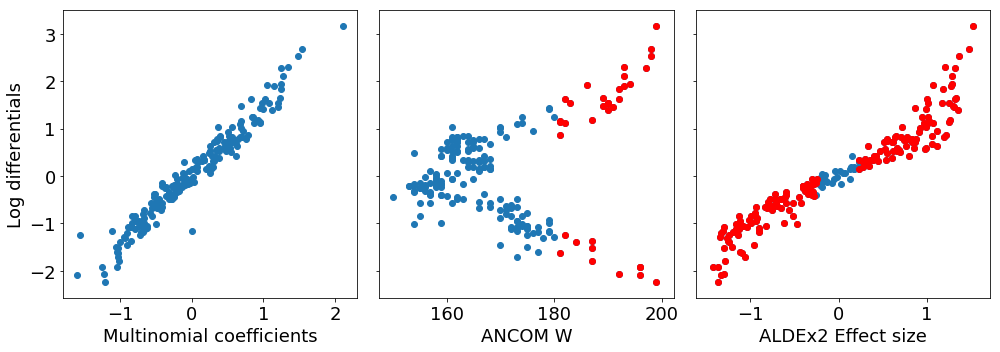

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
idx = rel_a1['detected_0.9']
fontsize = 18

ax[0].scatter(rel_m1.statistic, ground_truth1['categorical'])
ax[0].set_xlabel('Multinomial coefficients', fontsize=fontsize)
ax[0].set_ylabel('Log differentials', fontsize=fontsize)
ax[0].xaxis.set_tick_params(labelsize=fontsize)
ax[0].yaxis.set_tick_params(labelsize=fontsize)

ax[1].scatter(rel_a1.W_stat, ground_truth1['categorical'], label='')
ax[1].scatter(rel_a1.W_stat[idx], ground_truth1['categorical'].values[idx], 
              color='r', label='rejected null hypothesis')
ax[1].set_xlabel('ANCOM W', fontsize=fontsize)
#ax[1].set_ylabel('Log differentials', fontsize=fontsize)
ax[1].xaxis.set_tick_params(labelsize=fontsize)
ax[1].yaxis.set_tick_params(labelsize=fontsize)

idx = rel_x1['padj'] < 0.05
ax[2].scatter(rel_x1.effect, ground_truth1['categorical'])
ax[2].scatter(rel_x1.effect[idx], ground_truth1.loc[idx, 'categorical'], color='r')
ax[2].set_xlabel('ALDEx2 Effect size', fontsize=fontsize)
#ax[2].set_ylabel('Log differentials', fontsize=fontsize)
ax[2].xaxis.set_tick_params(labelsize=fontsize)
ax[2].yaxis.set_tick_params(labelsize=fontsize)

#ax[1].legend(fontsize=14)

plt.tight_layout() 

(-2.49675665538963, 3.430381332638051, -10.5, 209.5)

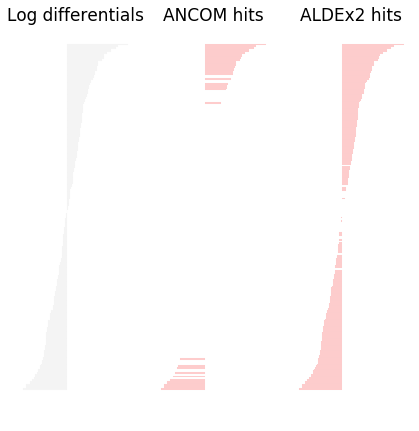

In [8]:
fontsize=17
coefs = ground_truth1['categorical'].sort_values()
x = np.arange(coefs.shape[0])
fig, ax = plt.subplots(1, 3, figsize=(7, 7))
ax[0].barh(x, coefs, 1, label='Ranks', 
           alpha=0.2, edgecolor='#D0D0D0', lw=0.1, color='#D0D0D0') #gray
ax[0].set_yticks([])
ax[0].set_title('Log differentials', fontsize=fontsize)

rel_a1s = rel_a1.loc[coefs.index]
idx = rel_a1s['detected_0.9']

x_ = [coefs.index.get_loc(i) for i in rel_a1s.index[idx]]
ax[1].barh(x_, coefs.loc[idx], 1, label='ANCOM', 
           alpha=0.2, edgecolor='#D0D0D0', lw=0.1, color='#FF0000') #red

#ax[1].set_ylabel('Taxa', fontsize=22)
#ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].set_yticks([])
ax[1].set_title('ANCOM hits', fontsize=fontsize)

rel_x1 = rel_x1.reindex(index=coefs.index)
idx = rel_x1['padj'] < 0.05
x_ = [coefs.index.get_loc(i) for i in rel_a1s.index[idx]]

ax[2].barh(x_, coefs.loc[idx], 1, label='ALDEx2', 
           alpha=0.2, edgecolor='#D0D0D0', lw=0.1, color='#FF0000') #red
ax[2].set_title('ALDEx2 hits', fontsize=fontsize)
_ = ax[2].set_yticks([])
#ax[2].set_xlabel('Log differentials', fontsize=22)
#ax.legend(fontsize=18)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [9]:
rel_m2 = run_multinomial(rel_table2, metadata2[['intercept', 'labels']])

# read in ancom2 results
rel_a2 = pd.read_csv(os.path.join(data_dir, 'ancom_rel_results2.csv'))
rel_a2 = rel_a2.set_index('otu.names')

rel_m2.to_csv(os.path.join(data_dir, 'multinomial_results2.txt'))

rel_x2 = pd.read_table(os.path.join(data_dir, 'aldex2_results2.txt'), sep=' ')
rel_x2 = rel_x2.set_index('category')

100%|██████████| 9300/9300 [00:09<00:00, 1014.94it/s]


In [10]:
# force ancom to be the same size
rel_a2 = rel_a2.reindex(index=ground_truth1.index)
rel_a2['W_stat'] = rel_a2['W_stat'].fillna(0)
rel_a2['detected_0.9'] = rel_a2['detected_0.9'].fillna(False)
rel_a2['detected_0.8'] = rel_a2['detected_0.8'].fillna(False)
rel_a2['detected_0.7'] = rel_a2['detected_0.7'].fillna(False)
rel_a2['detected_0.6'] = rel_a2['detected_0.6'].fillna(False)

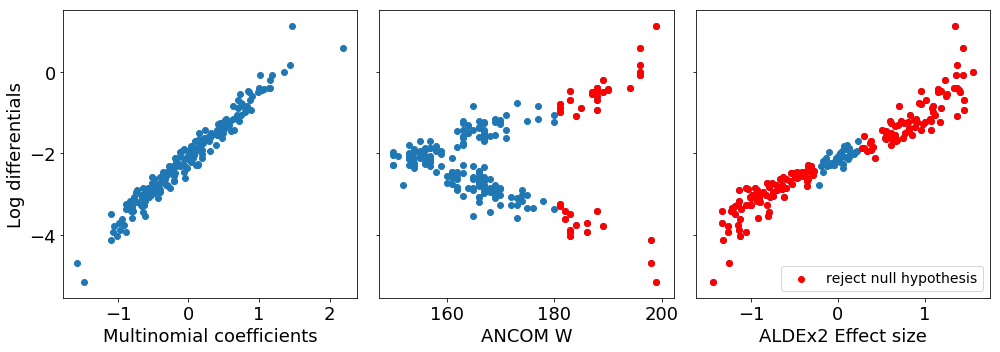

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
idx = rel_a2['detected_0.9']
fontsize = 18
ax[0].scatter(rel_m2.statistic, ground_truth2['categorical'])
#ax[0].scatter(rel_m2.statistic[idx], ground_truth2['categorical'].values[idx], c='r')
ax[0].set_xlabel('Multinomial coefficients', fontsize=fontsize)
ax[0].set_ylabel('Log differentials', fontsize=fontsize)
ax[0].xaxis.set_tick_params(labelsize=fontsize)
ax[0].yaxis.set_tick_params(labelsize=fontsize)

ax[1].scatter(rel_a2.W_stat, ground_truth2['categorical'], label='')
ax[1].scatter(rel_a2.W_stat[idx], ground_truth2['categorical'].values[idx], color='r')
ax[1].set_xlabel('ANCOM W', fontsize=fontsize)
#ax[1].set_ylabel('Log differentials', fontsize=fontsize)
ax[1].xaxis.set_tick_params(labelsize=fontsize)
ax[1].yaxis.set_tick_params(labelsize=fontsize)

idx = rel_x2['padj'] < 0.05
ax[2].scatter(rel_x2.effect, ground_truth2['categorical'], label='')
ax[2].scatter(rel_x2.effect[idx], ground_truth2.loc[idx, 'categorical'], color='r', label='reject null hypothesis')
ax[2].set_xlabel('ALDEx2 Effect size', fontsize=fontsize)
#ax[2].set_ylabel('Log differentials', fontsize=fontsize)
ax[2].xaxis.set_tick_params(labelsize=fontsize)
ax[2].yaxis.set_tick_params(labelsize=fontsize)
ax[2].legend(fontsize=14, loc=4)
plt.tight_layout() 

(-5.450887728146038, 1.428058250940845, -10.5, 209.5)

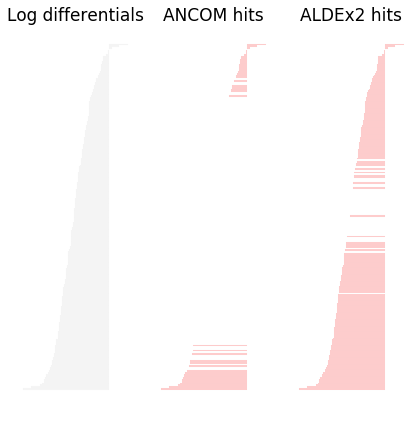

In [12]:
fontsize=17
coefs = ground_truth2['categorical'].sort_values()
x = np.arange(coefs.shape[0])
fig, ax = plt.subplots(1, 3, figsize=(7, 7))
ax[0].barh(x, coefs, 1, label='Ranks', 
           alpha=0.2, edgecolor='#D0D0D0', lw=0.1, color='#D0D0D0') #gray
ax[0].set_yticks([])
ax[0].set_title('Log differentials', fontsize=fontsize)

rel_a2s = rel_a2.loc[coefs.index]
idx = rel_a2s['detected_0.9']

x_ = [coefs.index.get_loc(i) for i in rel_a2s.index[idx]]
ax[1].barh(x_, coefs.loc[idx], 1, label='ANCOM', 
           alpha=0.2, edgecolor='#D0D0D0', lw=0.1, color='#FF0000') #red

#ax[1].set_ylabel('Taxa', fontsize=22)
#ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].set_yticks([])
ax[1].set_title('ANCOM hits', fontsize=fontsize)

rel_x2 = rel_x2.reindex(index=coefs.index)
idx = rel_x2['padj'] < 0.05
x_ = [coefs.index.get_loc(i) for i in rel_a2s.index[idx]]

ax[2].barh(x_, coefs.loc[idx], 1, label='ALDEx2', 
           alpha=0.2, edgecolor='#D0D0D0', lw=0.1, color='#FF0000') #red
ax[2].set_title('ALDEx2 hits', fontsize=fontsize)
_ = ax[2].set_yticks([])
#ax[2].set_xlabel('Log differentials', fontsize=22)
#ax.legend(fontsize=18)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

Summarize all of the outstanding results

In [13]:
np.sum(ground_truth2 < 0)[1]

197

In [14]:
np.sum(ground_truth2 < -1)[1]

172

In [15]:
rel_a2['detected_0.9'].sum()

43

In [16]:
np.percentile(ground_truth2['categorical'], q=95)

-0.4333480758997375

In [17]:
np.sum(ground_truth1['categorical'] > 1) + np.sum(ground_truth1['categorical'] < -1)

67

In [18]:
rel_a2['detected_0.9'].sum()

43